In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertMo

In [ ]:
df = pd.read_csv("/content/legal_text_classification.csv")[:1000]

In [ ]:
from sklearn.preprocessing import LabelEncoder
lab = LabelEncoder()

In [ ]:
df['case_outcome'] = lab.fit_transform(df['case_outcome'])

In [ ]:
def encode_data(data, max_len=128):
    titles = list(data['case_title'].astype(str).values)
    texts = list(data['case_text'].astype(str).values)

    encoded_title = tokenizer(
        titles,
        max_length=max_len,
        padding=True,
        truncation=True,
        return_tensors='tf'
    )

    encoded_text = tokenizer(
        texts,
        max_length=max_len,
        padding=True,
        truncation=True,
        return_tensors='tf'
    )

    return encoded_title, encoded_text


In [ ]:
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [ ]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [ ]:
punctuation = string.punctuation

In [ ]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punctuation))

In [ ]:
def get_wordnet_pos(tag):
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag[0].upper(), wordnet.NOUN)

In [ ]:
import string

def preprocess_text(text):

    if not isinstance(text, str):
        return text
    text = text.lower()

    text = text.translate(str.maketrans('', '', string.punctuation))

    words = text.split()

    processed_text = ' '.join(words)

    return processed_text


In [ ]:
df['case_title'] = df['case_title'].apply(preprocess_text)
df['case_text'] = df['case_text'].apply(preprocess_text)

In [ ]:
df.head()

,case_id,case_outcome,case_title,case_text
0,Case1,2,alpine hardwood aust pty ltd v hardys pty ltd ...,ordinarily that discretion will be exercised s...
1,Case2,2,black v lipovac 1998 fca 699 1998 217 alr 386,the general principles governing the exercise ...
2,Case3,2,colgate palmolive co v cussons pty ltd 1993 47...,ordinarily that discretion will be exercised s...
3,Case4,2,dais studio pty ltd v bullett creative pty ltd...,the general principles governing the exercise ...
4,Case5,2,dr martens australia pty ltd v figgins holding...,the preceding general principles inform the ex...


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df[['case_title', 'case_text']],
    df['case_outcome'],
    test_size=0.2,
    random_state=42
)

In [ ]:
train_encoded_title, train_encoded_text = encode_data(X_train)
test_encoded_title, test_encoded_text = encode_data(X_test)

In [ ]:
train_title_embeddings = bert_model(train_encoded_title['input_ids'], attention_mask=train_encoded_title['attention_mask'])
train_text_embeddings = bert_model(train_encoded_text['input_ids'], attention_mask=train_encoded_text['attention_mask'])
test_title_embeddings = bert_model(test_encoded_title['input_ids'], attention_mask=test_encoded_title['attention_mask'])
test_text_embeddings = bert_model(test_encoded_text['input_ids'], attention_mask=test_encoded_text['attention_mask'])

In [ ]:
class CustomBertModel(tf.keras.Model):
    def __init__(self, bert_model, num_classes):
        super(CustomBertModel, self).__init__()
        self.bert_text = bert_model
        self.bert_title = bert_model
        self.w1 = tf.Variable(initial_value=1.0, trainable=True, name="w1")
        self.w2 = tf.Variable(initial_value=1.0, trainable=True, name="w2")
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        input_ids_text, attention_mask_text, input_ids_title, attention_mask_title = inputs

        text_output = self.bert_text(input_ids_text, attention_mask=attention_mask_text, return_dict=True).last_hidden_state
        title_output = self.bert_title(input_ids_title, attention_mask=attention_mask_title, return_dict=True).last_hidden_state

        text_cls_embedding = text_output[:, 0, :]
        title_cls_embedding = title_output[:, 0, :]
        combined_output = self.w1 * text_cls_embedding + self.w2 * title_cls_embedding

        logits = self.classifier(combined_output)
        return logits


In [ ]:
num_classes = df['case_outcome'].nunique()
custom_bert_model = CustomBertModel(bert_model=bert_model, num_classes=num_classes)

In [ ]:
for layer in bert_model.layers:
    layer.trainable = True
bert_model.get_layer("bert").pooler.trainable = False

In [ ]:
custom_bert_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
train_input_ids_text = train_encoded_text['input_ids']
train_attention_mask_text = train_encoded_text['attention_mask']
train_input_ids_title = train_encoded_title['input_ids']
train_attention_mask_title = train_encoded_title['attention_mask']

test_input_ids_text = test_encoded_text['input_ids']
test_attention_mask_text = test_encoded_text['attention_mask']
test_input_ids_title = test_encoded_title['input_ids']
test_attention_mask_title = test_encoded_title['attention_mask']

In [ ]:
inputs = [
    train_input_ids_text, train_attention_mask_text,
    train_input_ids_title, train_attention_mask_title
]


In [ ]:
val_inputs = [
    test_input_ids_text, test_attention_mask_text,
    test_input_ids_title, test_attention_mask_title
]

In [ ]:
history = custom_bert_model.fit(
    inputs,
    y_train,
    validation_data=(val_inputs, y_test),
    epochs=5,
    batch_size=10
)

Epoch 1/5
80/80 [==============================] - 1846s 22s/step - loss: 1.6845 - accuracy: 0.4425 - val_loss: 1.5923 - val_accuracy: 0.4500
Epoch 2/5
80/80 [==============================] - 1759s 22s/step - loss: 1.4149 - accuracy: 0.5138 - val_loss: 1.5937 - val_accuracy: 0.4250
Epoch 3/5
80/80 [==============================] - 1755s 22s/step - loss: 1.0310 - accuracy: 0.6450 - val_loss: 1.5286 - val_accuracy: 0.4800
Epoch 4/5
80/80 [==============================] - 1777s 22s/step - loss: 0.5668 - accuracy: 0.8175 - val_loss: 1.9421 - val_accuracy: 0.5000
Epoch 5/5
80/80 [==============================] - 1782s 22s/step - loss: 0.2856 - accuracy: 0.9237 - val_loss: 1.9806 - val_accuracy: 0.5100


In [ ]:
custom_bert_model.save_weights("project_weights.h5")
loss, accuracy = custom_bert_model.evaluate(val_inputs, y_test)
print(f'Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}')

7/7 [==============================] - 125s 16s/step - loss: 1.9806 - accuracy: 0.5100
Validation Loss: 1.9806, Validation Accuracy: 0.5100


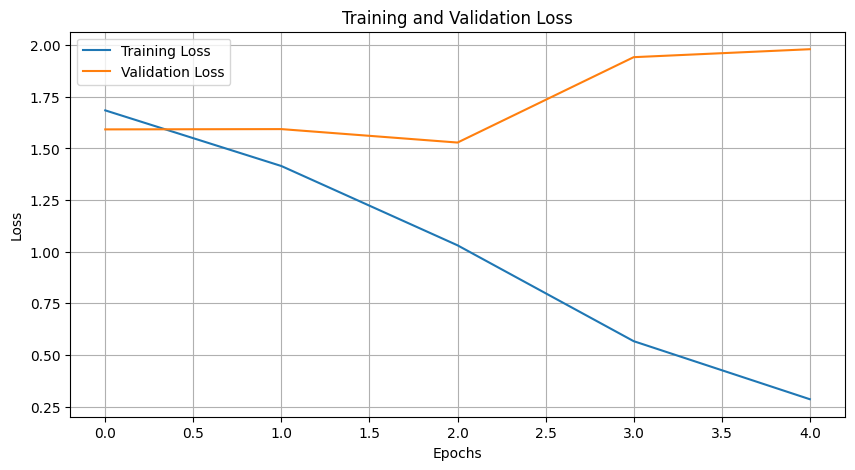

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

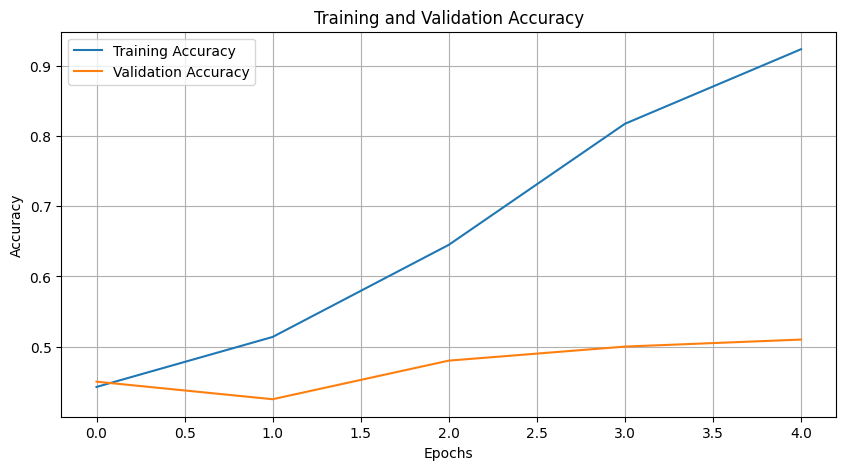

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
y_pred_probs = custom_bert_model.predict(val_inputs)
y_pred = np.argmax(y_pred_probs, axis=1)

7/7 [==============================] - 145s 19s/step


In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 0  0  1  0  0  0  0  0  0]
 [ 0  2 15  0  0  0  4  2  0]
 [ 0  2 65  8  2  0  3 10  0]
 [ 0  0  8  4  0  0  3  3  0]
 [ 0  0  0  1  1  0  1  5  0]
 [ 0  0  1  0  0  0  0  1  0]
 [ 0  0  8  1  1  0 10  3  0]
 [ 0  1  9  3  1  0  0 19  0]
 [ 0  0  1  0  0  0  0  0  1]]


<Figure size 1200x2400 with 0 Axes>

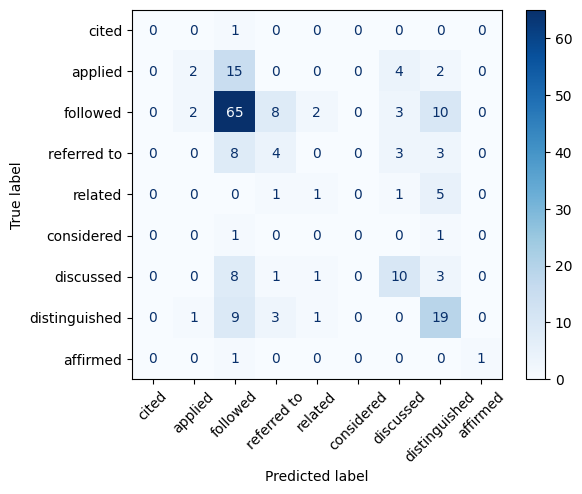

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lab.inverse_transform(df["case_outcome"].unique()))
plt.figure(figsize=(12, 24))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.40      0.09      0.14        23
           2       0.60      0.72      0.66        90
           3       0.24      0.22      0.23        18
           4       0.20      0.12      0.15         8
           5       0.00      0.00      0.00         2
           6       0.48      0.43      0.45        23
           7       0.44      0.58      0.50        33
           8       1.00      0.50      0.67         2

    accuracy                           0.51       200
   macro avg       0.37      0.30      0.31       200
weighted avg       0.48      0.51      0.48       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
indian_case_title = "India. Com, Inc. v. Dalal"
indian_case_text = "Dalal's motion for reconsideration of the April 18, 2006 Opinion entering judgment for the plaintiff EasyLink is denied."

In [ ]:
indian_case_title_processed = preprocess_text(indian_case_title)
indian_case_text_processed = preprocess_text(indian_case_text)

In [ ]:
indian_case_df = pd.DataFrame({'case_title': [indian_case_title_processed], 'case_text': [indian_case_text_processed]})
encoded_title, encoded_text = encode_data(indian_case_df)

In [ ]:
input_ids_text = encoded_text['input_ids']
attention_mask_text = encoded_text['attention_mask']
input_ids_title = encoded_title['input_ids']
attention_mask_title = encoded_title['attention_mask']

In [ ]:
inputs = [input_ids_text, attention_mask_text, input_ids_title, attention_mask_title]
pred_probs = custom_bert_model.predict(inputs)
predicted_class = np.argmax(pred_probs, axis=1)

1/1 [==============================] - 15s 15s/step


In [ ]:
outcome_label = lab.inverse_transform(predicted_class)
print("Predicted Outcome:", outcome_label[0])
"""In this legal context, "refer to" aligns with how the court’s language often specifies references to previous evidence, court orders, or findings, which are pivotal to the reasoning in judicial opinions. The court explicitly encouraged the parties to “refer to the detailed findings of fact made by the Court following trial” and to make arguments based on these or any overlooked trial record evidence. This direction highlights the emphasis on reviewing established evidence rather than introducing new facts, as Dalal sought to do in his motion for reconsideration. Therefore, "refer to" accurately fits this judicial style focused on established records and factual references in deliberations."""

Predicted Outcome: referred to


'In this legal context, "refer to" aligns with how the court’s language often specifies references to previous evidence, court orders, or findings, which are pivotal to the reasoning in judicial opinions. The court explicitly encouraged the parties to “refer to the detailed findings of fact made by the Court following trial” and to make arguments based on these or any overlooked trial record evidence. This direction highlights the emphasis on reviewing established evidence rather than introducing new facts, as Dalal sought to do in his motion for reconsideration. Therefore, "refer to" accurately fits this judicial style focused on established records and factual references in deliberations.'